In [6]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Patch
import seaborn as sns
import palettable as pal
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from descriptive_stats_table import descriptive_stats_table, overlay_tables
from dataframe_utils import data_get, vars_fill_nan

In [8]:
# Subject colors
subject_colors_lut = {
'NAION unilateral': '#BFD834',
'NAION bilateral': '#004d25',
'NAION': '#2AA10F',
'ODD-NAION': '#4242ff',
'Control': '#222222',
'ODD': '#C576F6'}

map_sections = {
    'rnfl':['S','T','I','N'],
    'gcc':['S','ST','IT','I','IN','SN'],
    'gh':['S','ST','T','IT','I','IN','N','SN'],
    'cq':['ST','IT','IN','SN'] }

## Import data

There are NAION unilateral, bilateral, non-specific, ODD-NAION and Controls in this dataset.
Some have repeat visits. Subjects in these groups are mutually exclusive. The goal is to analyse whether NAION patients vs Control differ in terms of their OCT, VF and FPF measurements. </br>
</br>
Analysis plan:</br>
--------------</br>
Comparison of control group and all patients/ all patient sub-groups.
- OCT, FPF, VF
- Scatterplot of mean HVF with FPF and with OCT
- Correlation matrix
- Clustermap



In [9]:
patient_group = 'naion'

In [11]:
data = data_get('1209-%s.csv' % patient_group)

independent_vars = 'group_binary'
identification_vars = ['id', 'months', 'visit_no']
dependent_vars = [d_var for d_var in data.columns for this_str in ['mean', 'oct', 'fpf', 'vf', 'hvf'] if d_var.startswith(this_str)]
data_variables = [independent_vars] + identification_vars + dependent_vars

data = data.groupby(['id', 'visit_no', independent_vars])[dependent_vars].mean().reset_index()   # This reduces nrows from 107 to 106, no real diff. I suspect there's a repeat in there somewhere.

print('Data shape: (%d, %d)' % data.shape)
print('Number of eyes: %d' % data['id'].nunique())

data = data[data['visit_no']==1].copy() # limit to first visit to not repeat!
print('Data shape of first visits only: (%d, %d)' % data.shape) 

Data shape: (103, 50)
Number of eyes: 77
Data shape of first visits only: (74, 50)


In [12]:
def cmap_hex_linspace(cmap, n_classes, palplot=False):
    new_cmap = plt.get_cmap(cmap)
    new_cmap_hex = []
    for i in np.linspace(0,255,n_classes+1):
        rgba = new_cmap(int(i))
        new_cmap_hex.append(colors.rgb2hex(rgba))
    if palplot:
        sns.palplot(new_cmap_hex)
    return new_cmap_hex

"""# Section colors
sect_hex = cmap_hex_linspace('hsv', n_classes=8) 
sect_lut = dict(zip(['S','ST','T','IT','I','IN','N','SN'], sect_hex))
sects = [var.split('_')[-1].upper() for var in subgroup_dependent_vars]
sects_reordered = [sects[i] for i in g.dendrogram_row.reordered_ind]
sects_reordered_colors = [sect_lut[k] for k in sects_reordered]
# haven't quite figured out how to retrospectively fit row colors."""

"# Section colors\nsect_hex = cmap_hex_linspace('hsv', n_classes=8) \nsect_lut = dict(zip(['S','ST','T','IT','I','IN','N','SN'], sect_hex))\nsects = [var.split('_')[-1].upper() for var in subgroup_dependent_vars]\nsects_reordered = [sects[i] for i in g.dendrogram_row.reordered_ind]\nsects_reordered_colors = [sect_lut[k] for k in sects_reordered]\n# haven't quite figured out how to retrospectively fit row colors."

<Figure size 640x480 with 0 Axes>

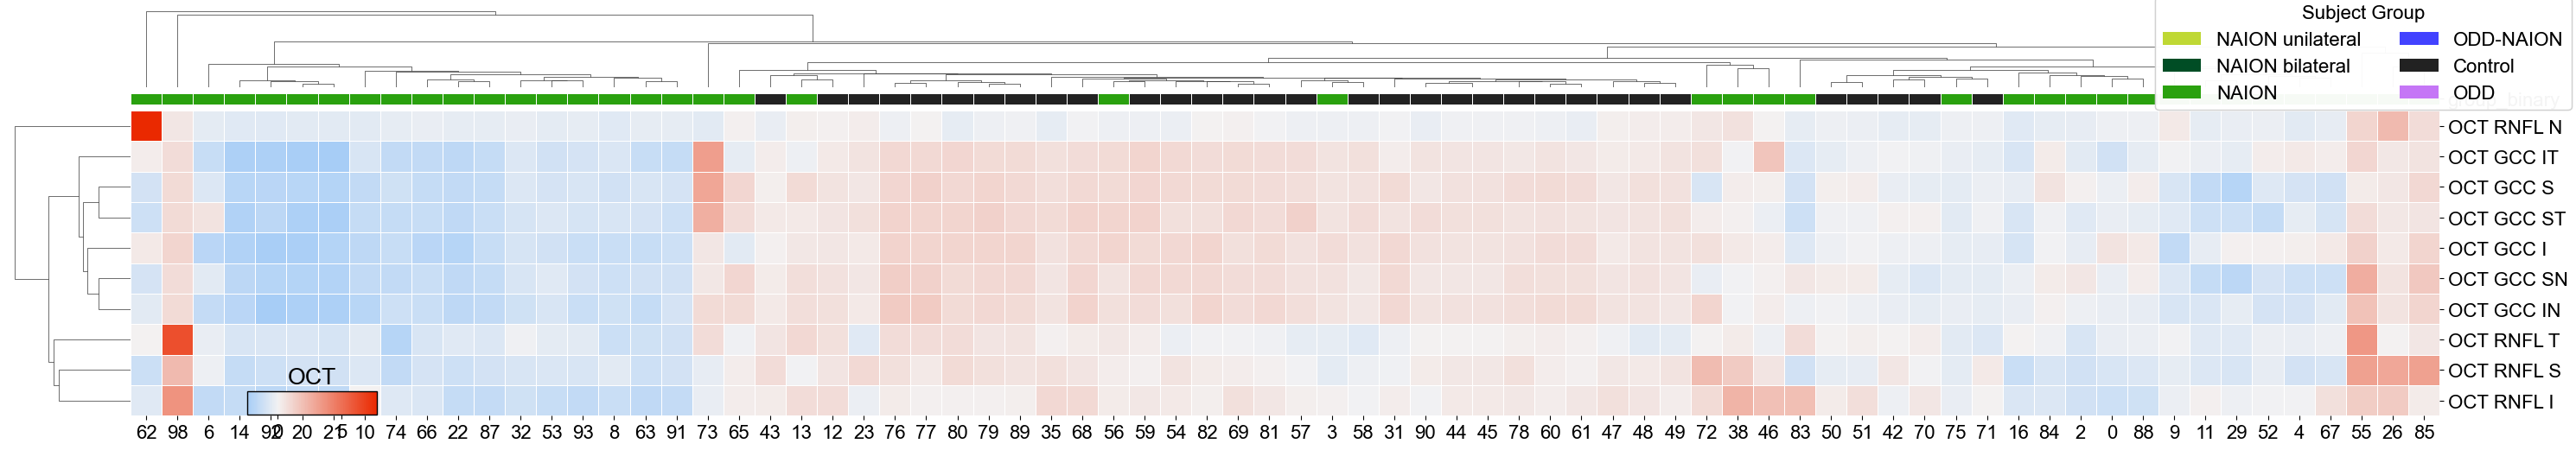

<Figure size 640x480 with 0 Axes>

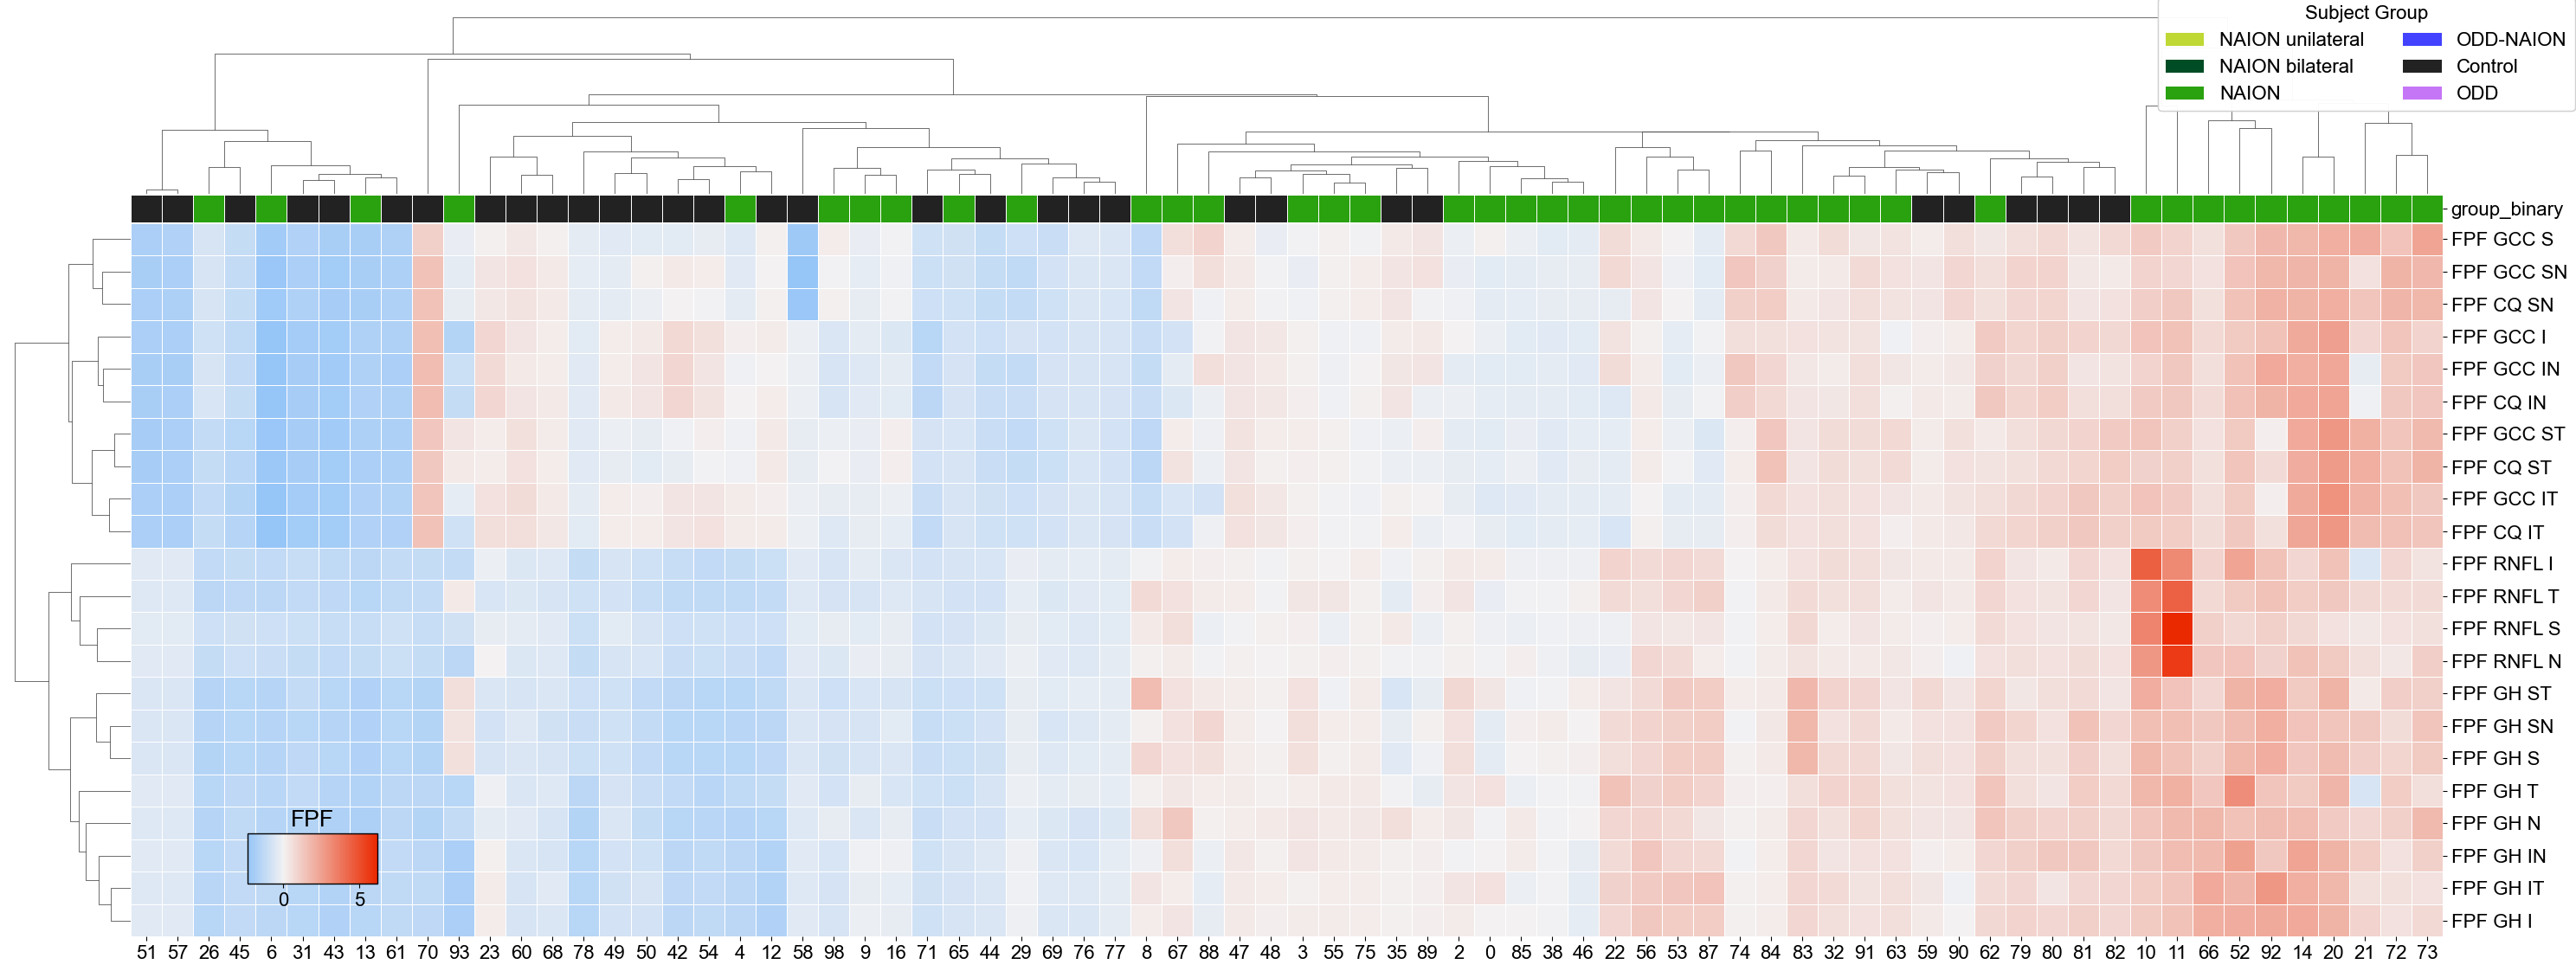

In [13]:
for sub_datatype in ['oct', 'fpf']:

    subgroup_dependent_vars = list(data.filter(regex=sub_datatype))
    subgroup_vars = subgroup_dependent_vars + [independent_vars]
    subgroup_data = data[subgroup_vars].copy()
    subgroup_data = vars_fill_nan(
        subgroup_data, d_vars=subgroup_dependent_vars, i_vars=independent_vars)
    
    # Standard scale the data
    scaler = StandardScaler()
    subgroup_data[subgroup_dependent_vars] = scaler.fit_transform(
        subgroup_data[subgroup_dependent_vars])

    # Get colormap
    cmap = sns.diverging_palette(250, 22, s=160, as_cmap=True)

    # Row/column colors
    var = independent_vars
    '''clm_groups = subgroup_data[var].unique().tolist()
    clm_hex = pal.cmocean.sequential.Algae_12.hex_colors
    clm_hex = clm_hex[1:len(clm_hex):2]
    clm_lut = dict(zip(clm_groups, clm_hex))'''

    clm_groups = subgroup_data[var].unique().tolist()
    clm_lut = subject_colors_lut
    clm_hex = subject_colors_lut.values()
    clm_colors = subgroup_data[var].map(clm_lut)

    matplotlib.rcParams["font.family"]      = "sans-serif"
    matplotlib.rcParams["font.sans-serif"]  = "Arial"
    matplotlib.rcParams["font.size"]        = 16

    f_height = subgroup_data.shape[1] * .5

    # Generate clustermap
    f = plt.figure()
    
    g = sns.clustermap(
        subgroup_data[subgroup_dependent_vars].T, 
        cmap=cmap,
        center=0, 
        figsize=(30,f_height), 
        col_colors=clm_colors,
        dendrogram_ratio=(.05,.2), 
        cbar_kws=dict(orientation='horizontal'),
        linewidth=.5)
    
    # Legend
    handles = [Patch(facecolor=clm_lut[name])for name in clm_lut]
    legend = plt.legend(handles, clm_lut, title='Subject Group', ncol=2, bbox_to_anchor=(1,1), bbox_transform=plt.gcf().transFigure, loc='upper right')
    plt.gca().add_artist(legend)
    
    
    # Colorbar
    spinecolor = 'k'
    spinewidth = 1
    g.ax_cbar.set_position((.1,.1,.05,.05))
    g.ax_cbar.set_title(sub_datatype.upper())
    #g.ax_cbar.set_xticks()
    #g.ax_cbar.set_xticklabels()
    for spine in g.ax_cbar.spines:
        g.ax_cbar.spines[spine].set_color(spinecolor)
        g.ax_cbar.spines[spine].set_linewidth(spinewidth)
    
    # Axis labels
    axes_object = g.ax_heatmap
    ticklabels = axes_object.get_yticklabels()
    ticklabels = [t.get_text().replace("_"," ").upper() for t in ticklabels]
    axes_object.set_yticklabels(ticklabels)

    plt.savefig('../output/%s/clustermap_%s.pdf' % (patient_group, sub_datatype))
    plt.show()

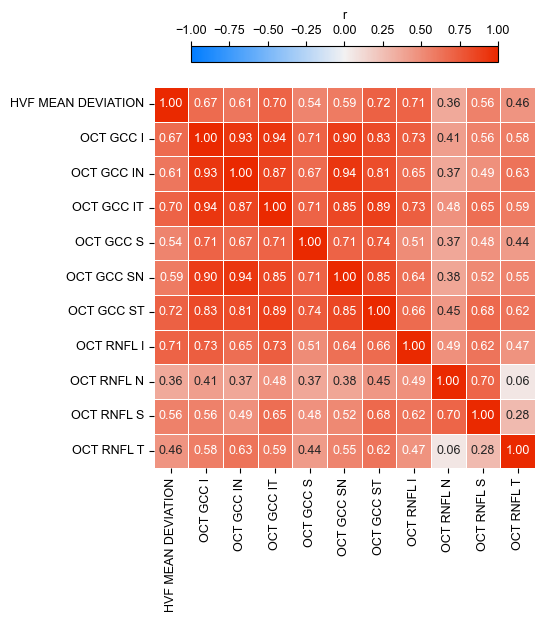

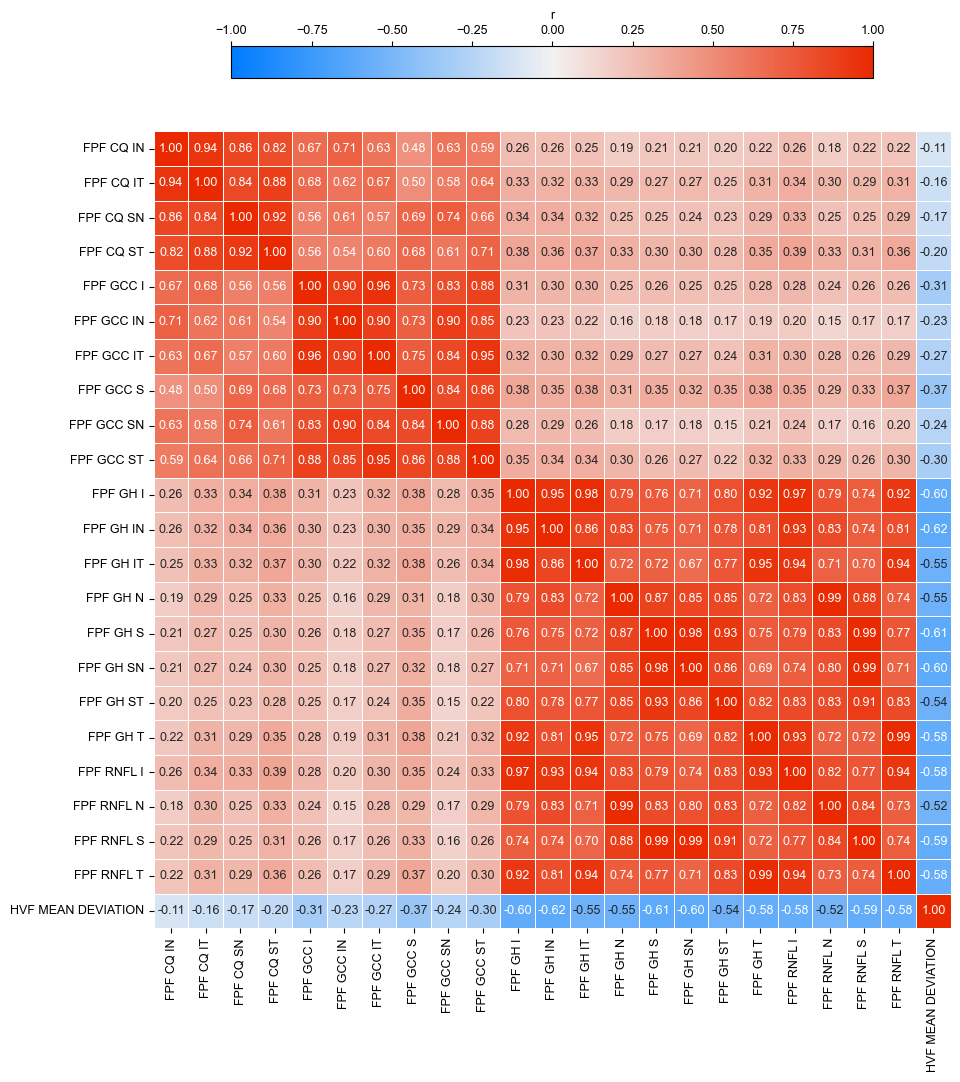

In [26]:
for sub_datatype in ['oct', 'fpf']:
    subgroup_dependent_vars = list(data.filter(regex=sub_datatype))
    subgroup_dependent_vars.extend(['hvf_mean_deviation'])
    subgroup_dependent_vars = sorted(list(set(subgroup_dependent_vars))) # no repeats
    data_corrmatrix = data[subgroup_dependent_vars].corr()
    fsize = data_corrmatrix.shape[0] * .6

    matplotlib.rcParams["font.family"]      = "sans-serif"
    matplotlib.rcParams["font.sans-serif"]  = "Arial"
    matplotlib.rcParams["font.size"]        = 9

    f = plt.figure(figsize=(fsize,fsize))

    g = sns.heatmap(
        data_corrmatrix,
        vmin=-1,
        vmax=1,
        cmap=cmap,
        annot=True,
        fmt='.2f',
        square=True,
        cbar=False,
        linewidth=.5)
    # axes object is g since this is a heatmap
    ticklabels = g.get_yticklabels()
    ticklabels = [t.get_text().replace("_"," ").upper() for t in ticklabels]
    g.set_xticklabels(ticklabels)
    g.set_yticklabels(ticklabels)

    spinecolor = 'k'
    spinewidth = 1

    cbar = g.figure.colorbar(
        g.collections[0],
        fraction=.2,
        shrink=.6,
        location='top',
        label='r')

<Figure size 600x200 with 0 Axes>

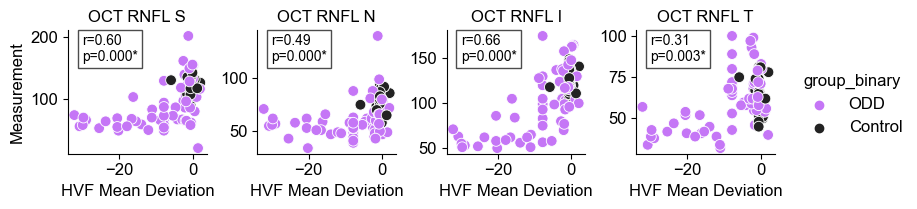

<Figure size 900x200 with 0 Axes>

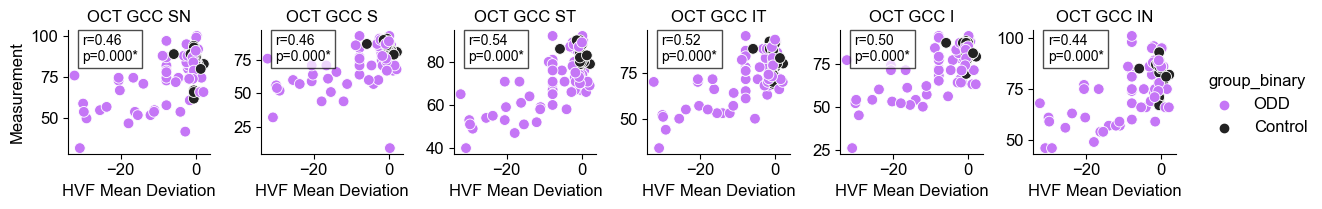

<Figure size 600x200 with 0 Axes>

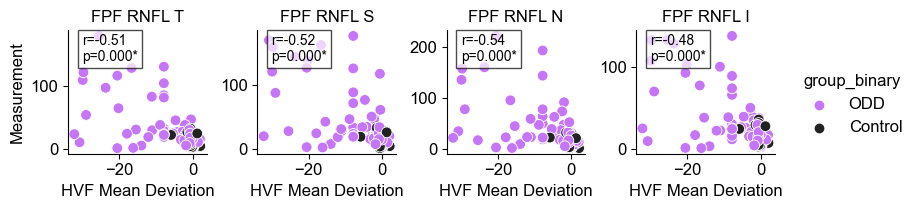

<Figure size 900x200 with 0 Axes>

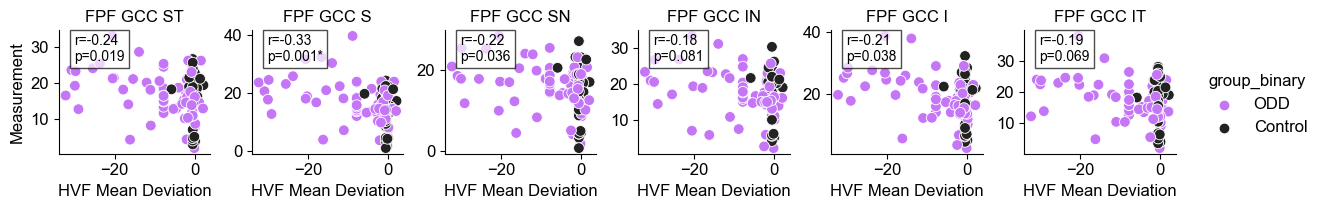

<Figure size 1200x200 with 0 Axes>

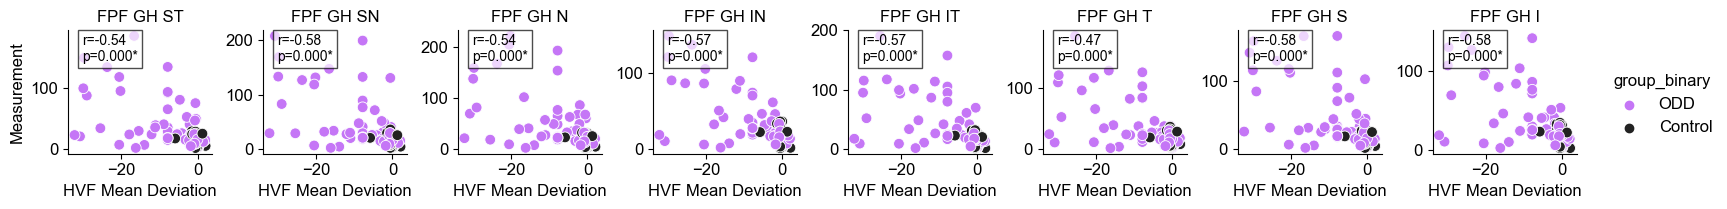

<Figure size 600x200 with 0 Axes>

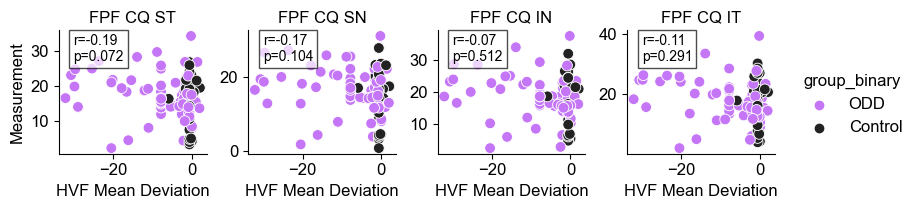

In [32]:
matplotlib.rcParams["font.family"]      = "sans-serif"
matplotlib.rcParams["font.sans-serif"]  = "Arial"
matplotlib.rcParams["font.size"]        = 12

for sub_datatype in ['oct', 'fpf']:

    subgroup_dependent_vars = list(data.filter(regex=sub_datatype))
    subgroup_vars = subgroup_dependent_vars + [independent_vars, 'id', 'hvf_mean_deviation']
    data_relplot = data[subgroup_vars].copy()
    data_relplot = pd.melt(data_relplot, id_vars=[independent_vars, 'id', 'hvf_mean_deviation'], value_vars=subgroup_dependent_vars)
    data_relplot['variable'] = data_relplot['variable'].apply(lambda x: x.replace('_',' ').upper())
    data_relplot['map'] = data_relplot['variable'].apply(lambda x: x.split(' ')[1])

    for this_map in data_relplot['map'].unique():
        dataset = data_relplot[data_relplot['map']==this_map]   
        # different fig for each map type
        n_cols = len(map_sections[this_map.lower()])

        results = {}
        alpha = .050

        for this_var in dataset['variable'].unique():
            d1 = dataset[dataset['variable']==this_var]['value'].values
            d2 = dataset[dataset['variable']==this_var]['hvf_mean_deviation'].values
            r,p = stats.spearmanr(d1,d2, nan_policy='omit',alternative='two-sided')
            # check bonferroni p values
            if p < (alpha/dataset['variable'].nunique()):
                results_str = 'r=%.2f\np=%.3f*' % (r,p)
            else:
                results_str = 'r=%.2f\np=%.3f' % (r,p)
            results[this_var] = [np.round(r,2), np.round(p,3), results_str]
        
        f = plt.figure(figsize=(n_cols*1.5,2))
        
        g = sns.relplot(
            kind='scatter',
            data=dataset, 
            x='hvf_mean_deviation',
            y='value',
            col='variable',
            col_wrap=n_cols,
            hue=independent_vars,
            s=60,
            facet_kws={'sharey':False},
            height=2.25,   # 2.25
            palette=clm_lut,
            aspect=.9,  #.9
            )

        (g.set_axis_labels("HVF Mean Deviation", "Measurement")
        .set_titles("{col_name}")
        .tight_layout(w_pad=.8, h_pad=.8)
        )
 
        props = dict(boxstyle='square', facecolor='white', alpha=.7)
        
        for i, this_var in enumerate(dataset['variable'].unique()):
            results_str = results[this_var][-1]
            g.axes[i].text(.1,.75, results_str, fontsize=10, bbox=props, transform=g.axes[i].transAxes)

        plt.savefig('../output/%s/relplots_%s_%s.pdf' % (patient_group, sub_datatype, this_map.lower()))

In [18]:
descriptive_stats = descriptive_stats_table(
    data,
    independent_vars=[independent_vars],
    identification_vars=identification_vars,
    dependent_vars=dependent_vars)

descriptive_stats_scale = descriptive_stats[0]
mu, sigma = descriptive_stats_scale[0], descriptive_stats_scale[1]
descriptive_stats_tbl = overlay_tables(mu, sigma, d_vars=dependent_vars)

display(descriptive_stats_tbl.iloc[:5,:10].head())
print(descriptive_stats_tbl.shape)

No nominal variables!


,group_binary,mean_rnfl,mean_gcc,oct_rnfl_s,oct_rnfl_n,oct_rnfl_i,oct_rnfl_t,oct_gcc_sn,oct_gcc_s,oct_gcc_st
0,Control,95.28 (6.14),81.92 (5.85),119.39 (14.64),74.72 (10.16),124.00 (11.05),63.23 (9.78),82.42 (7.27),82.42 (6.07),81.67 (5.84)
1,ODD,76.33 (20.35),72.24 (12.82),87.33 (35.53),59.80 (16.21),98.94 (34.25),59.79 (16.88),73.76 (15.26),70.36 (15.35),70.26 (12.35)


(2, 48)


,id,visit_no,group_binary,mean_rnfl,mean_gcc,oct_rnfl_s,oct_rnfl_n,oct_rnfl_i,oct_rnfl_t,oct_gcc_sn,...,vf_gh_st,vf_gh_it,vf_gh_n,vf_gh_t,vf_gh_s,vf_gh_i,vf_cq_sn,vf_cq_in,vf_cq_st,vf_cq_it
0,104_OD,1.0,ODD,103.0,94.0,129.0,88.0,130.0,64.0,97.0,...,-1.684545,-1.277273,-1.517273,-2.135455,-1.209091,-1.495455,-1.096364,-1.368182,-1.731818,-1.624545
1,104_OS,1.0,ODD,65.0,86.0,69.0,49.0,76.0,66.0,97.0,...,-1.684545,-1.277273,-1.517273,-2.135455,-1.209091,-1.495455,-1.096364,-1.368182,-1.731818,-1.624545
2,118_OD,1.0,ODD,89.0,88.0,92.0,57.0,107.0,99.0,90.0,...,-1.684545,-1.277273,-1.517273,-2.135455,-1.209091,-1.495455,-1.096364,-1.368182,-1.731818,-1.624545
3,118_OS,1.0,ODD,87.0,90.0,97.0,54.0,105.0,93.0,95.0,...,-1.684545,-1.277273,-1.517273,-2.135455,-1.209091,-1.495455,-1.096364,-1.368182,-1.731818,-1.624545
4,123_OD,1.0,ODD,66.0,76.0,62.0,50.0,102.0,50.0,83.0,...,1.760000,-0.760000,-0.470000,-0.940000,0.720000,-0.420000,-0.040000,-0.190000,1.110000,-0.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,403_OD,1.0,ODD,85.0,81.0,86.0,66.0,116.0,72.0,84.0,...,-1.684545,-1.277273,-1.517273,-2.135455,-1.209091,-1.495455,-1.096364,-1.368182,-1.731818,-1.624545
98,403_OS,1.0,ODD,65.0,75.0,58.0,50.0,96.0,58.0,79.0,...,-1.684545,-1.277273,-1.517273,-2.135455,-1.209091,-1.495455,-1.096364,-1.368182,-1.731818,-1.624545
99,40_OD,1.0,Control,89.0,81.0,117.0,65.0,111.0,62.0,80.0,...,2.900000,0.940000,2.080000,1.420000,2.140000,0.880000,-4.410000,-3.290000,-0.200000,0.890000
100,98_OD,1.0,ODD,91.0,74.0,128.0,57.0,118.0,63.0,74.0,...,-1.684545,-1.277273,-1.517273,-2.135455,-1.209091,-1.495455,-1.096364,-1.368182,-1.731818,-1.624545
